In [1]:
import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os
from typing import List, Dict, Any
from tqdm import tqdm

def run_benchmark(executable: str, thread_list: List[int], repetitions: int) -> pd.DataFrame:
    """
    Ejecuta el programa repetidamente con diferentes números de hilos
    y mide el tiempo de ejecución.

    Args:
        executable (str): Ruta al archivo ejecutable.
        thread_list (List[int]): Lista de números de hilos a probar.
        repetitions (int): Número de veces que se repite cada prueba.

    Returns:
        pd.DataFrame: Un DataFrame con los resultados de todas las ejecuciones.
    """
    if not os.path.exists(executable):
        raise FileNotFoundError(f"Error: El ejecutable '{executable}' no se encontró.")
    
    if not os.access(executable, os.X_OK):
        raise PermissionError(f"Error: El archivo '{executable}' no tiene permisos de ejecución.")

    resultados = []
    

FileNotFoundError: [Errno 2] No such file or directory: './paryee'

In [ ]:

    # Usamos tqdm para una barra de progreso
    print(f"Iniciando benchmark para '{executable}'...")
    total_runs = len(thread_list) * repetitions
    progress_bar = tqdm(total=total_runs, desc="Ejecutando pruebas", unit="run")

    for n_threads in thread_list:
        for i in range(repetitions):
            # Copiamos el entorno actual y añadimos la variable de OpenMP
            env = os.environ.copy()
            env["OMP_NUM_THREADS"] = str(n_threads)
            
            start_time = time.time()
            try:
                # Ejecutamos el proceso. check=True lanza una excepción si el proceso falla.
                # capture_output=True esconde la salida del proceso.
                subprocess.run([executable], env=env, check=True, capture_output=True, text=True)
            except subprocess.CalledProcessError as e:
                print(f"\n¡Error al ejecutar '{executable}' con {n_threads} hilos!")
                print(f"Stderr: {e.stderr}")
                raise
            end_time = time.time()
            
            elapsed = end_time - start_time
            resultados.append({
                "threads": n_threads,
                "run": i + 1,
                "time_s": elapsed
            })
            progress_bar.update(1)
            progress_bar.set_postfix_str(f"Threads: {n_threads}, Run: {i+1}, Time: {elapsed:.4f}s")

    progress_bar.close()
    return pd.DataFrame(resultados)

def process_and_save_results(df: pd.DataFrame, output_tsv: str) -> pd.DataFrame:
    """
    Guarda los resultados crudos en un archivo TSV y calcula estadísticas.

    Args:
        df (pd.DataFrame): DataFrame con los resultados crudos.
        output_tsv (str): Ruta del archivo TSV de salida.

    Returns:
        pd.DataFrame: DataFrame con los tiempos promediados y desviación estándar.
    """
    print(f"\nGuardando resultados crudos en '{output_tsv}'...")
    df.to_csv(output_tsv, sep="\t", index=False)

    # Agrupamos por hilos y calculamos la media y la desviación estándar
    df_agg = df.groupby("threads")["time_s"].agg(['mean', 'std']).reset_index()
    df_agg['std'] = df_agg['std'].fillna(0) # Rellenamos std con 0 si solo hay una repetición

    print("\nTiempos promediados:")
    print(df_agg)
    return df_agg



In [31]:
def plot_results(df_agg: pd.DataFrame, output_png: str, executable_name: str):
    """
    Genera y guarda una gráfica de rendimiento.

    Args:
        df_agg (pd.DataFrame): DataFrame con datos agregados (media, std).
        output_png (str): Ruta del archivo PNG de salida.
        executable_name (str): Nombre del ejecutable para el título del gráfico.
    """
    print(f"\nGenerando gráfica y guardando en '{output_png}'...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    # Graficar la línea de tiempo promedio
    plt.plot(df_agg["threads"], df_agg["mean"], marker='o', linestyle='-', color='red', label="Tiempo promedio")

    # Graficar el área de desviación estándar
    plt.fill_between(
        df_agg["threads"],
        df_agg["mean"] - df_agg["std"],
        df_agg["mean"] + df_agg["std"],
        color='red',
        alpha=0.2,
        label="Desviación estándar"
    )

    plt.xlabel("Número de hilos (OMP_NUM_THREADS)")
    plt.ylabel("Tiempo de ejecución [s]")
    plt.title(f"Rendimiento OpenMP - {executable_name}")
    plt.xticks(df_agg["threads"]) # Asegura que todos los puntos de hilos estén en el eje X
    plt.grid(True, which="both", linestyle='--')
    plt.legend()
    plt.savefig(output_png, dpi=300, bbox_inches='tight')
    plt.show()


def main():
    """Punto de entrada principal del script."""
    parser = argparse.ArgumentParser(
        description="Script para automatizar pruebas de rendimiento de un programa con OpenMP.",
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument("executable", type=str, help="Ruta al programa ejecutable a probar.")
    parser.add_argument("--threads", type=int, nargs='+', default=[1, 2, 4, 8, 16], help="Lista de número de hilos a probar.")
    parser.add_argument("--reps", type=int, default=3, help="Número de repeticiones por cada configuración de hilos.")
    parser.add_argument("--output-tsv", type=str, default="resultados_openmp.tsv", help="Nombre del archivo de salida para los resultados en formato TSV.")
    parser.add_argument("--output-png", type=str, default="rendimiento_openmp.png", help="Nombre del archivo de salida para la gráfica.")
    
    args = parser.parse_args()

    try:
        raw_results_df = run_benchmark(args.executable, args.threads, args.reps)
        aggregated_df = process_and_save_results(raw_results_df, args.output_tsv)
        executable_name = os.path.basename(args.executable)
        plot_results(aggregated_df, args.output_png, executable_name)
        print("\n¡Proceso de benchmark completado exitosamente!")
    except (FileNotFoundError, PermissionError, subprocess.CalledProcessError) as e:
        print(f"\nError: {e}")
        exit(1)

if __name__ == "__main__":
    main()

In [34]:
import subprocess

def run_make_data(binary, threads, gridlength=1000):
    try:
        print(f"\n▶ Ejecutando {binary} | Hilos = {threads}")
        bash_cmd = (
            f"make clean && make && "
            f"make {binary}.tsv threads={threads} gridlength={gridlength}"
        )
        subprocess.run(["bash", "-c", bash_cmd], check=True)
    except subprocess.CalledProcessError as e:
        print(f"❌ Error al ejecutar: {binary} con {threads} hilos")


In [35]:
omp_binaries = [
    "Linux_x86_64/output/yee_naive_omp",
    "Linux_x86_64/output/yee_block_omp",
    "Linux_x86_64/output/yee_stride1_omp"
]

threads_list = [1, 2, 4, 8, 16]

for binary in omp_binaries:
    for t in threads_list:
        run_make_data(binary, t, gridlength=1000)



▶ Ejecutando Linux_x86_64/output/yee_naive_omp | Hilos = 1

▶ Ejecutando Linux_x86_64/output/yee_naive_omp | Hilos = 2

▶ Ejecutando Linux_x86_64/output/yee_naive_omp | Hilos = 4

▶ Ejecutando Linux_x86_64/output/yee_naive_omp | Hilos = 8

▶ Ejecutando Linux_x86_64/output/yee_naive_omp | Hilos = 16

▶ Ejecutando Linux_x86_64/output/yee_block_omp | Hilos = 1

▶ Ejecutando Linux_x86_64/output/yee_block_omp | Hilos = 2

▶ Ejecutando Linux_x86_64/output/yee_block_omp | Hilos = 4

▶ Ejecutando Linux_x86_64/output/yee_block_omp | Hilos = 8

▶ Ejecutando Linux_x86_64/output/yee_block_omp | Hilos = 16

▶ Ejecutando Linux_x86_64/output/yee_stride1_omp | Hilos = 1

▶ Ejecutando Linux_x86_64/output/yee_stride1_omp | Hilos = 2

▶ Ejecutando Linux_x86_64/output/yee_stride1_omp | Hilos = 4

▶ Ejecutando Linux_x86_64/output/yee_stride1_omp | Hilos = 8

▶ Ejecutando Linux_x86_64/output/yee_stride1_omp | Hilos = 16


In [36]:
mpi 

NameError: name 'mpi' is not defined

In [6]:
import subprocess
import csv

mpi_binaries = ["yee_blocking_mpi", "yee_nonblock_mpi"]
nprocs_list = [1, 2, 4, 8, 16]
gridlength = 1000

with open('mpi_performance.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['binary', 'processes', 'elapsed_seconds'])
    for binary in mpi_binaries:
        for nprocs in nprocs_list:
            print(f"Ejecutando {binary} con {nprocs} procesos")
            try:
                result = subprocess.run([
                    "mpirun", "-np", str(nprocs),
                    f"./Linux_x86_64/bin/{binary}", str(gridlength)
                ], capture_output=True, text=True, check=True)
                # Buscar en la salida el tiempo, ej. línea que dice "Elapsed: 0.000473 seconds"
                for line in result.stdout.splitlines():
                    if "Elapsed:" in line:
                        time_sec = float(line.split()[1])
                        writer.writerow([binary, nprocs, time_sec])
                        break
            except Exception as e:
                print(f"Error ejecutando {binary} con {nprocs} procesos:", e)


Ejecutando yee_blocking_mpi con 1 procesos
Ejecutando yee_blocking_mpi con 2 procesos
Ejecutando yee_blocking_mpi con 4 procesos
Ejecutando yee_blocking_mpi con 8 procesos
Ejecutando yee_blocking_mpi con 16 procesos
Error ejecutando yee_blocking_mpi con 16 procesos: Command '['mpirun', '-np', '16', './Linux_x86_64/bin/yee_blocking_mpi', '1000']' returned non-zero exit status 1.
Ejecutando yee_nonblock_mpi con 1 procesos
Ejecutando yee_nonblock_mpi con 2 procesos
Ejecutando yee_nonblock_mpi con 4 procesos
Ejecutando yee_nonblock_mpi con 8 procesos
Ejecutando yee_nonblock_mpi con 16 procesos
Error ejecutando yee_nonblock_mpi con 16 procesos: Command '['mpirun', '-np', '16', './Linux_x86_64/bin/yee_nonblock_mpi', '1000']' returned non-zero exit status 1.


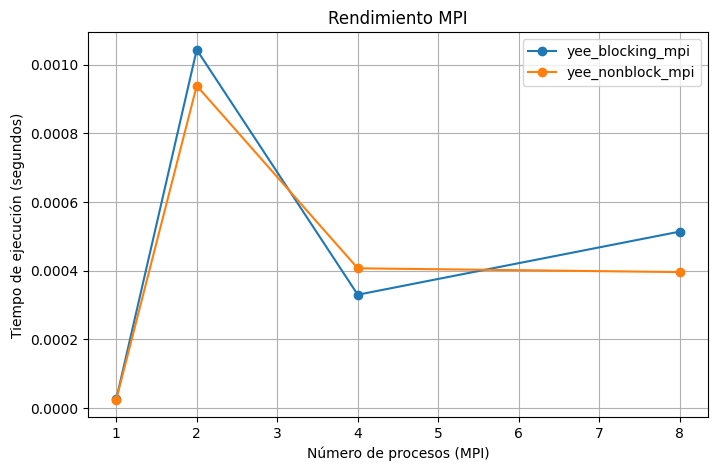

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('mpi_performance.csv')

plt.figure(figsize=(8,5))
for binary in df['binary'].unique():
    df_b = df[df['binary'] == binary]
    plt.plot(df_b['processes'], df_b['elapsed_seconds'], marker='o', label=binary)

plt.xlabel('Número de procesos (MPI)')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Rendimiento MPI')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
ls -l Linux_x86_64/bin/yee_*.mpi


El formato del parámetro no es correcto: "bin".


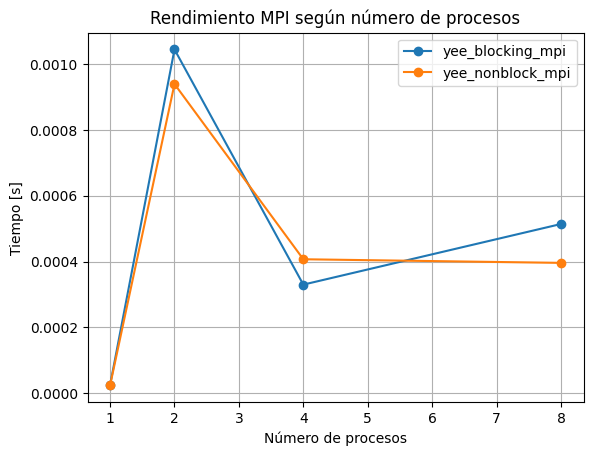

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("mpi_performance.csv")

# Para cada tipo de 'binary' (ej. yee_blocking_mpi, yee_nonblock_mpi)
for binary_name in df['binary'].unique():
    df_subset = df[df['binary'] == binary_name]
    # Ordenar por número de procesos para que la gráfica tenga sentido
    df_subset = df_subset.sort_values(by='processes')
    plt.plot(df_subset['processes'], df_subset['elapsed_seconds'], marker='o', label=binary_name)

plt.xlabel('Número de procesos')
plt.ylabel('Tiempo [s]')
plt.title('Rendimiento MPI según número de procesos')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import pandas as pd

df = pd.read_csv("mpi_performance.csv")

print("Columnas encontradas:")
print(df.columns.tolist())

print("\nPrimeras filas del DataFrame:")
print(df.head())


Columnas encontradas:
['binary', 'processes', 'elapsed_seconds']

Primeras filas del DataFrame:
             binary  processes  elapsed_seconds
0  yee_blocking_mpi          1         0.000025
1  yee_blocking_mpi          2         0.001044
2  yee_blocking_mpi          4         0.000330
3  yee_blocking_mpi          8         0.000514
4  yee_nonblock_mpi          1         0.000024
